In [1]:
#Import necessary library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.sparse
from scipy.sparse import csr_matrix

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator




spark = SparkSession.builder.master('local').appName('goodsRecommendation').getOrCreate()

In [2]:
#Read the CSV File containing the data
df_recommendation = spark.read.format('csv').options(header=True).load('Reviews.csv')
df_recommendation.show(30, truncate=50)
df_recommendation.printSchema()

+---+----------+--------------+-----------------------------------+--------------------+----------------------+-----+----------+--------------------------------------------------+--------------------------------------------------+
| Id| ProductId|        UserId|                        ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|                                           Summary|                                              Text|
+---+----------+--------------+-----------------------------------+--------------------+----------------------+-----+----------+--------------------------------------------------+--------------------------------------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|                         delmartian|                   1|                     1|    5|1303862400|                             Good Quality Dog Food|I have bought several of the Vitality canned do...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|                             dll pa|         

# Preprocessing and Cleaning

In [3]:
# Define a UDF function to remove quotes from the ProfileName

def remove_quotes(name):
    return name.replace('\"\"','*').strip('"').replace('*','"')

remove_quotes_udf = udf(lambda x: remove_quotes(x))

# Remove quotes from the ProfileName

df_recommendation = df_recommendation.withColumn('ProfileName', remove_quotes_udf('ProfileName'))
df_recommendation.show(30, truncate=50)

+---+----------+--------------+-------------------------------+--------------------+----------------------+-----+----------+--------------------------------------------------+--------------------------------------------------+
| Id| ProductId|        UserId|                    ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|                                           Summary|                                              Text|
+---+----------+--------------+-------------------------------+--------------------+----------------------+-----+----------+--------------------------------------------------+--------------------------------------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|                     delmartian|                   1|                     1|    5|1303862400|                             Good Quality Dog Food|I have bought several of the Vitality canned do...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|                         dll pa|                   0|        

In [4]:
df_recommendation.printSchema()

#Change Data Type Column Id, ProductId, UserId, HelpfulnessNumerator, HelpfulnessDenominator, Score, and Time from String to Int
df_recommendation = df_recommendation.withColumn('Id', df_recommendation['Id'].cast('int'))
df_recommendation = df_recommendation.withColumn('HelpfulnessNumerator', df_recommendation['HelpfulnessNumerator'].cast('int'))
df_recommendation = df_recommendation.withColumn('HelpfulnessDenominator', df_recommendation['HelpfulnessDenominator'].cast('int'))
df_recommendation = df_recommendation.withColumn('Score', df_recommendation['Score'].cast('int'))

#After changing data type
df_recommendation.printSchema()

root
 |-- Id: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: string (nullable = true)
 |-- HelpfulnessDenominator: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)

root
 |-- Id: integer (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- UserId: string (nullable = true)
 |-- ProfileName: string (nullable = true)
 |-- HelpfulnessNumerator: integer (nullable = true)
 |-- HelpfulnessDenominator: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Time: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Text: string (nullable = true)



In [5]:
#Check for null data
df_recommendation.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_recommendation.columns]).show()
df_recommendation.count()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|         34|                2751|                   886|  292|   5|      8|  10|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



568454

Banyak data yang memiliki nilai null sehingga kita harus melakukan cleaning data
Dikarenakan jumlah data yang dimiliki dapat dikatakan banya, maka kita akan menghapus row yang memiliki value null

In [6]:
# Remove null values (only score, product id, HelpfulnessNumerator, HelpfulnessDenominator because can't replace with other number)
df_recommendation = df_recommendation.dropna(subset=['ProductId','Score', 'HelpfulnessNumerator', 'HelpfulnessDenominator'])

# Check null values after cleaning
df_recommendation.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_recommendation.columns]).show()

+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|UserId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|         34|                   0|                     0|    0|   0|      2|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [7]:
#Change ProfileId, UserId ,Time, Summary, and Text

new_value = "Unknown"
df_recommendation_cleaned = df_recommendation \
    .withColumn("userId", when(df_recommendation["userId"].isNull(), "A1").otherwise(df_recommendation["userId"])) \
    .withColumn("Summary", when(df_recommendation["Summary"].isNull(), new_value).otherwise(df_recommendation["Summary"])) \
    .withColumn("Text", when(df_recommendation["Text"].isNull(), new_value).otherwise(df_recommendation["Text"])) \
    .withColumn("Time", when(df_recommendation["Time"].isNull(), new_value).otherwise(df_recommendation["Time"])) \

df_recommendation_cleaned = df_recommendation_cleaned.withColumn("ProfileName", lower(df_recommendation_cleaned["ProfileName"])) \
    .withColumn("Time", lower(df_recommendation_cleaned["Time"])) \
    .withColumn("Summary", lower(df_recommendation_cleaned["Summary"]))


df_recommendation_cleaned = df_recommendation_cleaned.withColumn("ProfileName", regexp_replace("ProfileName", "nan", new_value)) \
    .withColumn("Time", regexp_replace("Time", "nan", new_value)) \
    .withColumn("Summary", regexp_replace("Summary", "nan", new_value))
df_recommendation_cleaned.select([count((when(isnan(c) | isnull(c), 1))).alias(c) for c in df_recommendation_cleaned.columns]).show()


+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
| Id|ProductId|userId|ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|Time|Summary|Text|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+
|  0|        0|     0|          0|                   0|                     0|    0|   0|      0|   0|
+---+---------+------+-----------+--------------------+----------------------+-----+----+-------+----+



In [8]:
df_recommendation_cleaned.count()

565703

# EDA

In [9]:
df_recommendation_cleaned.show()
df_recommendation_cleaned.printSchema()

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        userId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|good quality dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   not as advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|natalia corres "n...|                   1|                     1|    4|1219017600|"""delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                karl|            

In [10]:
df_recommendation_cleaned.select('Score').groupby('Score').count().show()

+-----+------+
|Score| count|
+-----+------+
|    1| 52125|
|    3| 42360|
|    5|361565|
|    4| 80055|
|    2| 29598|
+-----+------+



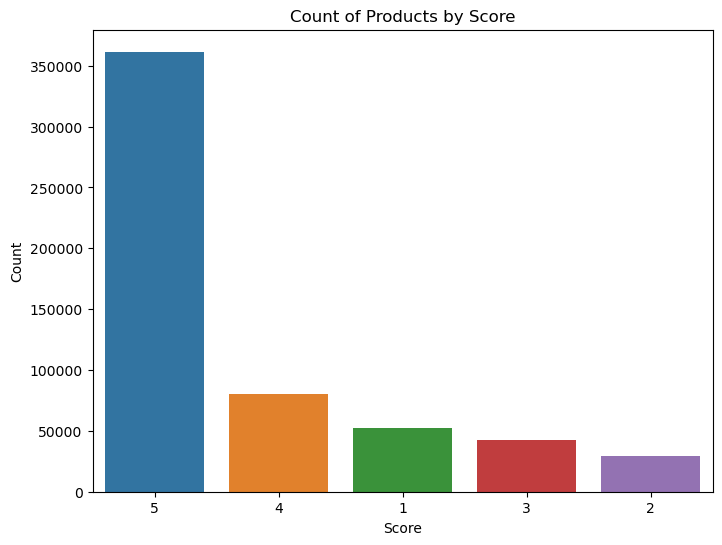

In [11]:
# Jumlah product berdasarkan score
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = df_recommendation_cleaned.select('Score').toPandas()

# Plotting the data
plt.figure(figsize=(8, 6))
sns.countplot(x='Score', data=pandas_df, order=pandas_df['Score'].value_counts().index)

# Add labels and title
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Count of Products by Score')
plt.show()


In [12]:
product_id_score =  df_recommendation_cleaned.groupBy("ProductId").count().orderBy('count', ascending=False)
product_id_score.show()

+----------+-----+
| ProductId|count|
+----------+-----+
|B007JFMH8M|  911|
|B002QWHJOU|  630|
|B0026RQTGE|  630|
|B002QWP89S|  630|
|B002QWP8H0|  630|
|B003B3OOPA|  622|
|B001EO5Q64|  567|
|B0013NUGDE|  563|
|B0026KNQSA|  563|
|B0026KPDG8|  563|
|B007M832YY|  563|
|B007M83302|  563|
|B001RVFERK|  563|
|B001RVFEP2|  563|
|B000VK8AVK|  563|
|B006HYLW32|  563|
|B000KV7ZGQ|  556|
|B000KV61FC|  556|
|B005K4Q1YA|  542|
|B005K4Q37A|  542|
+----------+-----+
only showing top 20 rows



# Training Data

In [13]:
final_df = df_recommendation_cleaned.select(['UserId','ProductId','Score'])
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(final_df) for col in ['UserId', 'ProductId']]
pipeline = Pipeline(stages=indexers)
final_df = pipeline.fit(final_df).transform(final_df)
final_df.show()

+--------------+----------+-----+----------+-------------+
|        UserId| ProductId|Score|UserId_idx|ProductId_idx|
+--------------+----------+-----+----------+-------------+
|A3SGXH7AUHU8GW|B001E4KFG0|    5|  209215.0|      52892.0|
|A1D87F6ZCVE5NK|B00813GRG4|    1|   97503.0|      72999.0|
| ABXLMWJIXXAIN|B000LQOCH0|    4|   45417.0|      48455.0|
|A395BORC6FGVXV|B000UA0QIQ|    2|   42292.0|      50220.0|
|A1UQRSCLF8GW1T|B006K2ZZ7K|    5|   55215.0|      24501.0|
| ADT0SRK1MGOEU|B006K2ZZ7K|    4|  226488.0|      24501.0|
|A1SP2KVKFXXRU1|B006K2ZZ7K|    5|   54745.0|      24501.0|
|A3JRGQVEQN31IQ|B006K2ZZ7K|    5|  198149.0|      24501.0|
|A1MZYO9TZK0BBI|B000E7L2R4|    5|   53398.0|      46719.0|
|A21BT40VZCCYT4|B00171APVA|    5|   26360.0|      51932.0|
|A3HDKO7OW0QNK4|B0001PB9FE|    5|   30412.0|      44859.0|
|A2725IB4YY9JEB|B0009XLVG0|    5|    4715.0|      32629.0|
| A327PCT23YH90|B0009XLVG0|    1|   65693.0|      32629.0|
|A18ECVX2RJ7HUE|B001GVISJM|    4|    1694.0|       6673.

In [14]:
df_positive_values = final_df.filter(col('Score') <= 0)

# Show the filtered DataFrame
df_positive_values.show()

+------+---------+-----+----------+-------------+
|UserId|ProductId|Score|UserId_idx|ProductId_idx|
+------+---------+-----+----------+-------------+
+------+---------+-----+----------+-------------+



In [15]:
#Train Data
(trainData, testData) = final_df.randomSplit([0.8, 0.2], seed=42)

In [16]:
testData.printSchema()
type(testData)

root
 |-- UserId: string (nullable = true)
 |-- ProductId: string (nullable = true)
 |-- Score: integer (nullable = true)
 |-- UserId_idx: double (nullable = false)
 |-- ProductId_idx: double (nullable = false)



pyspark.sql.dataframe.DataFrame

In [17]:
#Building the model

als = ALS(userCol="UserId_idx", itemCol="ProductId_idx", ratingCol="Score",
          coldStartStrategy="drop", nonnegative=True)
model = als.fit(trainData)
type(als)

pyspark.ml.recommendation.ALS

In [18]:
prediction = model.transform(testData)
prediction.show(200)
prediction.printSchema()

+--------------+----------+-----+----------+-------------+----------+
|        UserId| ProductId|Score|UserId_idx|ProductId_idx|prediction|
+--------------+----------+-----+----------+-------------+----------+
|A2SZLNSI5KOQJT|B006N3HWGS|    5|      10.0|       5300.0|  3.990918|
|A2FRFAQCWZJT3Q|B005VOOM4A|    5|      15.0|        148.0| 4.3066897|
|A1LZJZIHUPLDV4|B000LL0RC4|    5|      18.0|       9852.0|  5.223937|
|A2Y8IDC1FKGNJC|B005VOOM4A|    5|      20.0|        148.0| 4.1917977|
| ADS5APY1NKTL4|B005VOOM4A|    5|      35.0|        148.0| 4.5305915|
|A3FKGKUCI3DG9U|B006Q7YG56|    3|      36.0|        833.0| 3.2157345|
|A1P2XYD265YE21|B000JZYM8C|    5|      39.0|       1342.0|  4.347884|
|A36MP37DITBU6F|B001BLXSVK|    5|      40.0|       5803.0| 3.9936247|
|A2R6RA8FRBS608|B0048D4KPG|    5|      41.0|      29993.0| 4.5299616|
|A17HMM1M7T9PJ1|B0030GT28C|    4|      46.0|       1829.0| 2.4970803|
|A250AXLRBVYKB4|B001CC734G|    5|      47.0|      22097.0|  6.459416|
|A24ZV048V7J0MT|B003

In [19]:
evaluator = RegressionEvaluator(metricName = "rmse", labelCol="Score", predictionCol="prediction")
RMSE = evaluator.evaluate(prediction)
print("Root Mean Squared Error: " + str(RMSE))

Root Mean Squared Error: 1.194197627259156


## Making A Recommendation

In [20]:
user_recommends = model.recommendForAllUsers(5)


In [21]:
user_recommends.select("UserId_idx", "recommendations.ProductId_idx").show(truncate=100)

+----------+-----------------------------------+
|UserId_idx|                      ProductId_idx|
+----------+-----------------------------------+
|         1|[27889, 14987, 14836, 14986, 14988]|
|         3|[59262, 22768, 57764, 19441, 39149]|
|         5|[39534, 64382, 30332, 14985, 14988]|
|         6|[47496, 40979, 32535, 72185, 72184]|
|         9|[24437, 19635, 30683, 18166, 25955]|
|        12|[39534, 17306, 13717, 50348, 27979]|
|        13|[39534, 68345, 19478, 30332, 23860]|
|        15|[15201, 39376, 67643, 22659, 68798]|
|        16|[39534, 57764, 50348, 15795, 39149]|
|        17|[39534, 15795, 12066, 14985, 14988]|
|        19|[39534, 68345, 22120, 61384, 18640]|
|        20|[29388, 38468, 50348, 13424, 33744]|
|        22|[39534, 27889, 29044, 36446, 15795]|
|        26|[36715, 45643, 40132, 53988, 51983]|
|        27| [39534, 23860, 9650, 31153, 28290]|
|        28|[39534, 30332, 64382, 39828, 62167]|
|        31|[39515, 32535, 32536, 27979, 27978]|
|        34|[40856, 

In [22]:
single_user_prediction = testData.filter(testData['UserId_idx'] == 1.0).select(['UserId_idx','UserId', 'ProductId_idx', 'ProductId'])

In [23]:
single_user_prediction.show()

+----------+--------------+-------------+----------+
|UserId_idx|        UserId|ProductId_idx| ProductId|
+----------+--------------+-------------+----------+
|       1.0|A1YUL9PCJR3JTY|      44823.0|B0001M0ZZC|
|       1.0|A1YUL9PCJR3JTY|      24909.0|B0001M0ZZW|
|       1.0|A1YUL9PCJR3JTY|      24909.0|B0001M0ZZW|
|       1.0|A1YUL9PCJR3JTY|       1153.0|B0009F3SA0|
|       1.0|A1YUL9PCJR3JTY|       1133.0|B0009F3SBY|
|       1.0|A1YUL9PCJR3JTY|        416.0|B000CQC050|
|       1.0|A1YUL9PCJR3JTY|        416.0|B000CQC050|
|       1.0|A1YUL9PCJR3JTY|        852.0|B000CQC0BE|
|       1.0|A1YUL9PCJR3JTY|        418.0|B000CQG87Q|
|       1.0|A1YUL9PCJR3JTY|        420.0|B000CQID2Y|
|       1.0|A1YUL9PCJR3JTY|       3744.0|B000EUIZ8K|
|       1.0|A1YUL9PCJR3JTY|      47451.0|B000H1VBNC|
|       1.0|A1YUL9PCJR3JTY|      21395.0|B000M7NH8I|
|       1.0|A1YUL9PCJR3JTY|      21395.0|B000M7NH8I|
|       1.0|A1YUL9PCJR3JTY|      13733.0|B000NU8H0C|
|       1.0|A1YUL9PCJR3JTY|      21544.0|B000P

In [24]:
recommendation = model.transform(single_user_prediction)

In [25]:
recommendation.show()

+----------+--------------+-------------+----------+----------+
|UserId_idx|        UserId|ProductId_idx| ProductId|prediction|
+----------+--------------+-------------+----------+----------+
|       1.0|A1YUL9PCJR3JTY|      36706.0|B001I7IN6W| 3.9269092|
|       1.0|A1YUL9PCJR3JTY|      16224.0|B001I7PNKQ| 4.9989805|
|       1.0|A1YUL9PCJR3JTY|       4078.0|B0000DBN2I| 3.4416072|
|       1.0|A1YUL9PCJR3JTY|      21545.0|B000PSPREG| 5.3870125|
|       1.0|A1YUL9PCJR3JTY|        799.0|B001EO5QZK| 3.7361693|
|       1.0|A1YUL9PCJR3JTY|        804.0|B001EO5TJ8| 3.7307236|
|       1.0|A1YUL9PCJR3JTY|       1133.0|B0009F3SBY| 3.9427962|
|       1.0|A1YUL9PCJR3JTY|      36694.0|B001I4EDNW| 3.9269092|
|       1.0|A1YUL9PCJR3JTY|       3744.0|B000EUIZ8K| 4.5391836|
|       1.0|A1YUL9PCJR3JTY|      16370.0|B001W2H61G| 4.9953117|
|       1.0|A1YUL9PCJR3JTY|      21570.0|B000QVDP6Y| 5.0161633|
|       1.0|A1YUL9PCJR3JTY|       1729.0|B001ELL4X6| 3.0791578|
|       1.0|A1YUL9PCJR3JTY|        416.0

In [26]:
type(recommendation)
recommendation_sorted = recommendation.orderBy(recommendation['prediction'].desc())
recommendation_sorted.show(n=5)

+----------+--------------+-------------+----------+----------+
|UserId_idx|        UserId|ProductId_idx| ProductId|prediction|
+----------+--------------+-------------+----------+----------+
|       1.0|A1YUL9PCJR3JTY|      21545.0|B000PSPREG| 5.3870125|
|       1.0|A1YUL9PCJR3JTY|      20559.0|B00028MJ2M|  5.361866|
|       1.0|A1YUL9PCJR3JTY|      21544.0|B000PSNJXC|  5.293704|
|       1.0|A1YUL9PCJR3JTY|      14620.0|B003ULE1E2| 5.1947103|
|       1.0|A1YUL9PCJR3JTY|      12911.0|B003ULL816|  5.146568|
+----------+--------------+-------------+----------+----------+
only showing top 5 rows



### Use items which haven't been bought by user id 1.0 to recommend the best item for user id 1.0

In [30]:
all_items_df = final_df.select("ProductId_idx").distinct()

items_bought_by_user_1 = final_df.filter(col("UserId_idx") == 1).select("ProductId_idx")

items_not_bought_by_user_1 = all_items_df.join(items_bought_by_user_1, on="ProductId_idx", how="left_anti")

user_id = 1
items_not_bought = items_not_bought_by_user_1.withColumn("UserId_idx", col("ProductId_idx") * 0 + user_id)
items_not_bought.show()


+-------------+----------+
|ProductId_idx|UserId_idx|
+-------------+----------+
|      63867.0|       1.0|
|       6454.0|       1.0|
|      55041.0|       1.0|
|      43284.0|       1.0|
|      52435.0|       1.0|
|      12737.0|       1.0|
|      21309.0|       1.0|
|      20948.0|       1.0|
|      29728.0|       1.0|
|      56427.0|       1.0|
|      17267.0|       1.0|
|      41060.0|       1.0|
|      54175.0|       1.0|
|      54050.0|       1.0|
|      13094.0|       1.0|
|      45605.0|       1.0|
|      12172.0|       1.0|
|      18436.0|       1.0|
|      22797.0|       1.0|
|      58327.0|       1.0|
+-------------+----------+
only showing top 20 rows



In [31]:
recommendation = model.transform(items_not_bought)
recommendation.show()


+-------------+----------+----------+
|ProductId_idx|UserId_idx|prediction|
+-------------+----------+----------+
|      63867.0|       1.0| 2.8506272|
|       6454.0|       1.0| 3.3819628|
|      43284.0|       1.0|  4.304305|
|      12737.0|       1.0| 3.5351522|
|      21309.0|       1.0| 3.2157352|
|      20948.0|       1.0| 3.6952322|
|      29728.0|       1.0| 2.6454108|
|      17267.0|       1.0| 4.6338043|
|      41060.0|       1.0| 1.4142597|
|      54175.0|       1.0| 1.2183068|
|      54050.0|       1.0| 3.3723752|
|      13094.0|       1.0|  5.170857|
|      45605.0|       1.0| 1.5579095|
|      12172.0|       1.0| 4.7177615|
|      18436.0|       1.0| 5.2810698|
|      22797.0|       1.0|  5.553661|
|      58327.0|       1.0| 5.1279874|
|      42594.0|       1.0|  4.222077|
|      71444.0|       1.0| 2.1319091|
|      12493.0|       1.0| 4.7461905|
+-------------+----------+----------+
only showing top 20 rows



In [32]:
print("Top 5 Food Product Recommendation with Highest Score 6.9")
recommendation.show()

print("Top 5 Food Product Recommendation with Highest Score 5")
filtered_recommendation = recommendation.filter(col("prediction") <= 5 )
filtered_recommendation.show()

Top 5 Food Product Recommendation with Highest Score 6.9
+-------------+----------+----------+
|ProductId_idx|UserId_idx|prediction|
+-------------+----------+----------+
|      63867.0|       1.0| 2.8506272|
|       6454.0|       1.0| 3.3819628|
|      43284.0|       1.0|  4.304305|
|      12737.0|       1.0| 3.5351522|
|      21309.0|       1.0| 3.2157352|
|      20948.0|       1.0| 3.6952322|
|      29728.0|       1.0| 2.6454108|
|      17267.0|       1.0| 4.6338043|
|      41060.0|       1.0| 1.4142597|
|      54175.0|       1.0| 1.2183068|
|      54050.0|       1.0| 3.3723752|
|      13094.0|       1.0|  5.170857|
|      45605.0|       1.0| 1.5579095|
|      12172.0|       1.0| 4.7177615|
|      18436.0|       1.0| 5.2810698|
|      22797.0|       1.0|  5.553661|
|      58327.0|       1.0| 5.1279874|
|      42594.0|       1.0|  4.222077|
|      71444.0|       1.0| 2.1319091|
|      12493.0|       1.0| 4.7461905|
+-------------+----------+----------+
only showing top 20 rows

Top 5

## Show top 5 Product with highest score for User Id 1

In [33]:
print("Top 5 Food Product Recommendation with Highest Score 6.9")
recommendation_sorted_wofilter = recommendation.orderBy(recommendation['prediction'].desc())
recommendation_sorted_wofilter.show(n=5)

print("Top 5 Food Product Recommendation with Highest Score 5")
recommendation_sorted = filtered_recommendation.orderBy(recommendation['prediction'].desc())
recommendation_sorted.show(n=5)

Top 5 Food Product Recommendation with Highest Score 6.9
+-------------+----------+----------+
|ProductId_idx|UserId_idx|prediction|
+-------------+----------+----------+
|      27889.0|       1.0|  6.836885|
|      14987.0|       1.0| 6.7330446|
|      14836.0|       1.0|  6.702823|
|      14986.0|       1.0|  6.697756|
|      14988.0|       1.0| 6.6963167|
+-------------+----------+----------+
only showing top 5 rows

Top 5 Food Product Recommendation with Highest Score 5
+-------------+----------+----------+
|ProductId_idx|UserId_idx|prediction|
+-------------+----------+----------+
|       7588.0|       1.0|  4.999893|
|      10375.0|       1.0|  4.999887|
|      10482.0|       1.0|  4.999723|
|       9093.0|       1.0|  4.999678|
|      20553.0|       1.0|  4.999637|
+-------------+----------+----------+
only showing top 5 rows



In [39]:
#Product Names from another datasets

In [40]:
df_name = spark.read.format('csv').options(header=True).load('amazonFood.csv')
df_name = df_name.withColumnRenamed("UserID", "UserID_B")
df_name.show(30, truncate=50)
df_name.printSchema()

+----------+--------------+--------------------------------------------------+-----+--------------------------------------------------+--------------------------------------------------+
| ProductId|      UserID_B|                                       productName|Score|                                           Summary|                                              Text|
+----------+--------------+--------------------------------------------------+-----+--------------------------------------------------+--------------------------------------------------+
|B001E4KFG0|A3SGXH7AUHU8GW|       Dogswell Vitality Canned Dog Food Case Duck|    5|                             Good Quality Dog Food|I have bought several of the Vitality canned do...|
|B00813GRG4|A1D87F6ZCVE5NK|Southern Grove Premium Quality Roasted and Salt...|    1|                                 Not as Advertised|"Product arrived labeled as Jumbo Salted Peanut...|
|B000LQOCH0| ABXLMWJIXXAIN|Turkish Delight Filbert (Hazelnuts) (S

In [44]:
df_products = df_name.select(['ProductId','productName'])
indexers = [StringIndexer(inputCol=col, outputCol=col+'_idx').fit(df_products) for col in [ 'ProductId']]
pipeline = Pipeline(stages=indexers)
df_products = pipeline.fit(df_products).transform(df_products)
df_products.show()

+----------+--------------------+-------------+
| ProductId|         productName|ProductId_idx|
+----------+--------------------+-------------+
|B001E4KFG0|Dogswell Vitality...|       3654.0|
|B00813GRG4|Southern Grove Pr...|       5018.0|
|B000LQOCH0|Turkish Delight F...|       3340.0|
|B000UA0QIQ|Faeries Finest Fl...|       3461.0|
|B006K2ZZ7K|Salt Water Taffy ...|       1778.0|
|B006K2ZZ7K|Salt Water Taffy ...|       1778.0|
|B006K2ZZ7K|Salt Water Taffy ...|       1778.0|
|B006K2ZZ7K|Salt Water Taffy ...|       1778.0|
|B000E7L2R4|Organic Barley Se...|       3194.0|
|B00171APVA|Eukanuba Natural ...|       3587.0|
|B0001PB9FE|Original Tequila ...|       3050.0|
|B0009XLVG0|Canidae All Life ...|       2279.0|
|B0009XLVG0|Canidae All Life ...|       2279.0|
|B001GVISJM|TWIZZLERS Twists,...|        510.0|
|B001GVISJM|TWIZZLERS Twists,...|        510.0|
|B001GVISJM|TWIZZLERS Twists,...|        510.0|
|B001GVISJM|TWIZZLERS Twists,...|        510.0|
|B001GVISJM|TWIZZLERS Twists,...|       

In [46]:
joined_df1 = df_products.join(recommendation_sorted_wofilter, on="ProductId_idx", how="inner")
joined_df2 = df_products.join(recommendation_sorted, on="ProductId_idx", how="inner")

In [48]:
print("Joined DataFrame All:")
joined_df1.show()

print("Joined DataFrame Under 5:")
joined_df1.show()

Joined DataFrame All:
+-------------+----------+--------------------+----------+----------+
|ProductId_idx| ProductId|         productName|UserId_idx|prediction|
+-------------+----------+--------------------+----------+----------+
|       2734.0|B003ZDWMGO|Lucini Italia Tra...|       1.0|  4.865537|
|       2734.0|B003ZDWMGO|Polish Dill Pickl...|       1.0|  4.865537|
|       2815.0|B004MTMYNQ|Cheetos Crunchy F...|       1.0|  4.346771|
|       2815.0|B004MTMYNQ|Cheetos Crunchy F...|       1.0|  4.346771|
|       2862.0|B0056CSBO4|Faeries Finest Fl...|       1.0|  3.275492|
|       2862.0|B0056CSBO4|Napoleon Perla Pa...|       1.0|  3.275492|
|        769.0|B0000CDBRP|Chef Paul Prudhom...|       1.0| 2.8767471|
|        769.0|B0000CDBRP|Chef Paul Prudhom...|       1.0| 2.8767471|
|        769.0|B0000CDBRP|Chef Paul Prudhom...|       1.0| 2.8767471|
|        769.0|B0000CDBRP|Chef Paul Prudhom...|       1.0| 2.8767471|
|        769.0|B0000CDBRP|Chef Paul Prudhom...|       1.0| 2.8767471

In [52]:
df1_no_duplicates = joined_df1.dropDuplicates()
df2_no_duplicates = joined_df2.dropDuplicates()

print('Final Result with All Predictions : ')
df1_no_duplicates.show()

print('Final Result with Prediction under 5 : ')
df2_no_duplicates.show()

Final Result with All Predictions : 
+-------------+----------+--------------------+----------+----------+
|ProductId_idx| ProductId|         productName|UserId_idx|prediction|
+-------------+----------+--------------------+----------+----------+
|       1683.0|B002KNY7RC|Royal Pet Supplie...|       1.0|  2.742775|
|       1135.0|B000J36EQC|Celestial Seasoni...|       1.0|  2.662858|
|       1324.0|B000JWGFRG|Walden Farms Dres...|       1.0| 2.6009102|
|        858.0|B004JWS0CA|Timothy's World C...|       1.0|   2.54002|
|       1953.0|B001C2CM60|Canidae Dog Treat...|       1.0| 4.3676386|
|       2289.0|B000C4QQ16|Coopers DIY Beer ...|       1.0| 3.3344333|
|        116.0|B00389Q4XW|Keurig Green Moun...|       1.0| 2.9199066|
|       2183.0|B005NDXHAY|Old-Fashioned Chr...|       1.0| 4.2591596|
|        258.0|B002BCE9JS|Iams Veterinary F...|       1.0| 3.5287197|
|       3091.0|B0004LYJ84|Hunt's Milk Choco...|       1.0| 2.5005333|
|       2306.0|B000FA3980|Sociables Baked C...|      

In [60]:
df_sorted1 = df1_no_duplicates.orderBy(df1_no_duplicates["prediction"].desc())
df_sorted2 = df2_no_duplicates.orderBy(df2_no_duplicates["prediction"].desc())


df_sorted1.show()
df_sorted2.show()

+-------------+----------+--------------------+----------+----------+
|ProductId_idx| ProductId|         productName|UserId_idx|prediction|
+-------------+----------+--------------------+----------+----------+
|       4286.0|B0043320ZS|CELSIUS Essential...|       1.0| 6.0721054|
|       4285.0|B0042GXRMQ|See's Candies 1 l...|       1.0|  6.051318|
|       4284.0|B0042GLX0Y|Nescafe Gold Blen...|       1.0|  5.992488|
|       3906.0|B00290RPPC|Hunt's Snack Pack...|       1.0|  5.948937|
|       4908.0|B00724ENGY|Friskies Sea Capt...|       1.0| 5.7928624|
|       4140.0|B003FSWRY6|Lawry's Szechuan ...|       1.0| 5.7803173|
|       4170.0|B003KDCJYY|All Day Energy 2o...|       1.0| 5.7774453|
|       1917.0|B000VSDCH4|Indomie Instant F...|       1.0|  5.737784|
|       2519.0|B001FA1K5S|Nestle Nesquik Po...|       1.0|  5.696372|
|       2519.0|B001FA1K5S|Cameron's Coffee ...|       1.0|  5.696372|
|       4339.0|B0046H89Z6|Italian Products ...|       1.0|  5.675676|
|       3934.0|B002B

## Show top 5 Product with highest score for User Id 1 using model.recommendForUserSubset

In [35]:
userID = recommendation.filter(recommendation['UserId_idx'] == 1)
recommendation_forUserSubset = model.recommendForUserSubset(userID, 5)
recommendation_forUserSubset.select("UserId_idx", "recommendations.ProductId_idx").show(truncate=100)
recommendation_forUserSubset.select("UserId_idx", "recommendations.rating").show(truncate=100)

+----------+-----------------------------------+
|UserId_idx|                      ProductId_idx|
+----------+-----------------------------------+
|         1|[27889, 14987, 14836, 14986, 14988]|
+----------+-----------------------------------+

+----------+------------------------------------------------------+
|UserId_idx|                                                rating|
+----------+------------------------------------------------------+
|         1|[6.8368855, 6.7330446, 6.702823, 6.6977553, 6.6963167]|
+----------+------------------------------------------------------+

